In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm

sys.path.append("../utils")

# user = "leilanie"
# util_path = f"/capstone/wildfire_prep/{user}/data-preparation/code/utils"
# sys.path.append(util_path)

import config
import data_utils
import planet_api
import planet_utils

In [2]:
PLANET_API_KEY = planet_api.key
planet = planet_utils.PlanetAPI(PLANET_API_KEY, planet_utils.basemap_url)
mosaic_names = planet.get_mosaics()

mosaic_names = [name for name in mosaic_names if "monthly" in name]
mosaic_names

['global_monthly_2016_01_mosaic',
 'global_monthly_2016_02_mosaic',
 'global_monthly_2016_03_mosaic',
 'global_monthly_2016_04_mosaic',
 'global_monthly_2016_05_mosaic',
 'global_monthly_2016_06_mosaic',
 'global_monthly_2016_07_mosaic',
 'global_monthly_2016_08_mosaic',
 'global_monthly_2016_09_mosaic',
 'global_monthly_2016_10_mosaic',
 'global_monthly_2016_11_mosaic',
 'global_monthly_2016_12_mosaic',
 'global_monthly_2017_01_mutate_mosaic',
 'global_monthly_2017_02_mosaic',
 'global_monthly_2017_03_mosaic',
 'global_monthly_2017_04_mosaic',
 'global_monthly_2017_05_mosaic',
 'global_monthly_2017_06_mosaic',
 'global_monthly_2017_07_mosaic',
 'global_monthly_2017_08_mosaic',
 'global_monthly_2017_09_mosaic',
 'global_monthly_2017_10_mosaic',
 'global_monthly_2017_11_mosaic',
 'global_monthly_2017_12_mosaic',
 'global_monthly_2018_01_mosaic',
 'global_monthly_2018_02_mosaic',
 'global_monthly_2018_03_mosaic',
 'global_monthly_2018_04_mosaic',
 'global_monthly_2018_05_mosaic',
 'globa

In [3]:
# mosaic = "global_monthly_2022_12_mosaic"
mosaic_names = ["global_monthly_2022_12_mosaic"]

<Axes: >

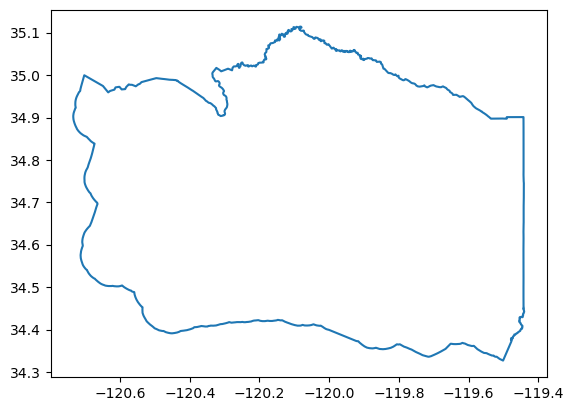

In [4]:
counties = gpd.read_file(
    os.path.join(config.data_dir, "ca_counties", "CA_Counties.shp")
)
counties = counties.to_crs(config.geodetic_crs)
sb_county = counties.loc[counties["NAME"] == "Santa Barbara"]
bbox = [-125, 34.25, -119.0, 38.0]
sb_county = sb_county.clip(bbox)
sb_county.boundary.plot()

In [5]:
sb_grid = data_utils.create_grid(
    sb_county,
    resolution=0.01,
    geometry_col="geometry",
    id_col="NAME",
    return_ids=True,
)
sb_grid_gdf = gpd.GeoDataFrame(
    sb_grid,
    geometry=gpd.points_from_xy(sb_grid.lon, sb_grid.lat),
    crs="EPSG:4326",
)
sb_grid_gdf.geometry = sb_grid_gdf.geometry.buffer(0.005, cap_style=3)

print(f"Shape (row, col): {sb_grid_gdf.shape}")

sb_grid_gdf.head()

Shape (row, col): (7507, 5)


/tmp/ipykernel_53714/2638617555.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sb_grid_gdf.geometry = sb_grid_gdf.geometry.buffer(0.005, cap_style=3)


,lat,lon,NAME,unique_id,geometry
0,35.115,-120.085,Santa Barbara,lon_-120.085__lat_35.115,"POLYGON ((-120.08 35.12, -120.08 35.11, -120.0..."
1,35.105,-120.115,Santa Barbara,lon_-120.115__lat_35.105,"POLYGON ((-120.11 35.11, -120.11 35.1, -120.12..."
2,35.105,-120.105,Santa Barbara,lon_-120.105__lat_35.105,"POLYGON ((-120.1 35.11, -120.1 35.1, -120.11 3..."
3,35.105,-120.095,Santa Barbara,lon_-120.095__lat_35.105,"POLYGON ((-120.09 35.11, -120.09 35.1, -120.1 ..."
4,35.105,-120.085,Santa Barbara,lon_-120.085__lat_35.105,"POLYGON ((-120.08 35.11, -120.08 35.1, -120.09..."


In [6]:
planet.set_mosaic(mosaic_names[0])
bbox_aoi = sb_county.geometry.total_bounds
all_items = planet.get_items(bbox_aoi)
quad_df = planet.convert_items_to_geodataframe(all_items)
quad_df = quad_df.drop_duplicates(subset="id")

quad_df = quad_df.sjoin(sb_county, predicate="intersects")
quad_df.drop(columns=["index_right"], inplace=True)
quad_df.head()

,id,geometry,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area
0,338-1236,"POLYGON ((-120.58594 34.88593, -120.41016 34.8...",06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,...,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10
1,344-1235,"POLYGON ((-119.53125 34.74161, -119.35547 34.7...",06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,...,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10
2,340-1235,"POLYGON ((-120.23438 34.74161, -120.05859 34.7...",06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,...,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10
3,337-1234,"POLYGON ((-120.76172 34.59704, -120.58594 34.5...",06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,...,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10
4,339-1236,"POLYGON ((-120.41016 34.88593, -120.23438 34.8...",06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,...,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10


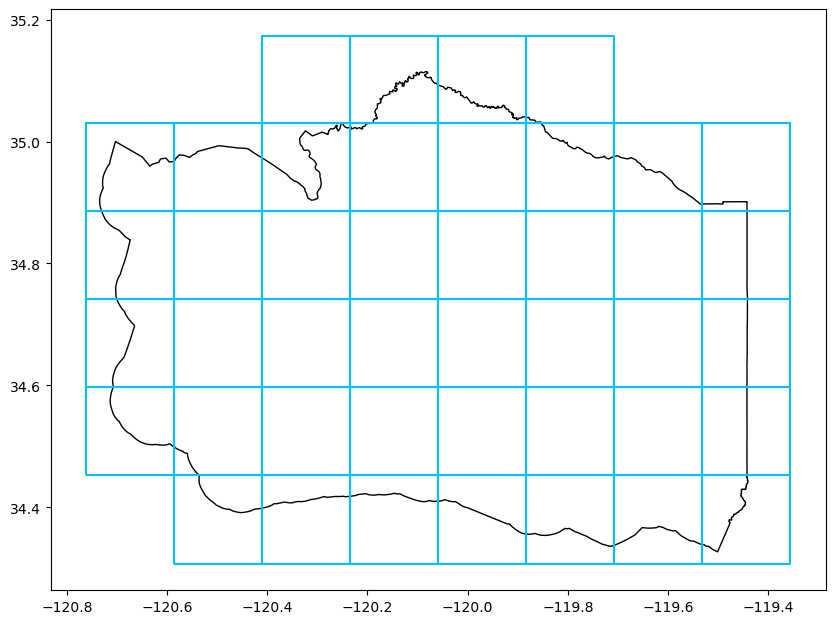

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

quad_df.boundary.plot(ax=ax, edgecolor="grey", color="deepskyblue")
sb_county.plot(ax=ax, color="None", edgecolor="black")

plt.show()

In [8]:
intersecting = gpd.sjoin(
    sb_grid_gdf.reset_index(),
    quad_df,
    how="left",
    predicate="intersects",
)

sb_grid_gdf["id"] = intersecting.groupby("index")["id"].apply(list).values

sb_grid_gdf = sb_grid_gdf[~sb_grid_gdf["id"].apply(data_utils.contains_nan)]

sb_grid_gdf = sb_grid_gdf.to_crs(config.geodetic_crs)

file_dir = os.path.join(config.basemap_dir, mosaic_names[0], "quad_ids")
os.makedirs(file_dir, exist_ok=True)

quad_fn = os.path.join(file_dir, "quad_ids.geojson")
quad_df.to_file(quad_fn, driver="GeoJSON")

grid_fn = os.path.join(file_dir, "sb_grid_gdf.parquet")
sb_grid_gdf.to_parquet(grid_fn)

In [9]:
for mosaic in sorted(mosaic_names, reverse=True):
    print(f"Processing {mosaic}...", end="\n")
    mosaic_dir = config.basemap_dir + "/" + mosaic
    quad_dir = mosaic_dir + "/basemap_quads"
    quad_id_fp = mosaic_dir + "/quad_ids/quad_ids.geojson"

    quad_df = gpd.read_file(quad_id_fp, driver="GeoJSON")

    quad_ids_list = quad_df.id.tolist()

    os.makedirs(quad_dir, exist_ok=True)
    existing_files = os.listdir(quad_dir)

    filtered_quad_ids_list = planet_utils.filter_existing_quad_ids(
        quad_ids_list, existing_files
    )
    chunked_quad_id_list = planet_utils.chunk_list(filtered_quad_ids_list, 100)

    print(f"N Quads: {len(quad_ids_list)}")
    print(f"N Quads Remaining: {len(filtered_quad_ids_list)}")
    print(f"N Chunks: {len(chunked_quad_id_list)}")

    for i in range(len(chunked_quad_id_list)):
        print(f"Chunk: {i + 1}/{len(chunked_quad_id_list)}", end="\n")

        order_params = {
            "name": "Basemap order with geometry",
            "source_type": "basemaps",
            "order_type": "partial",
            "products": [
                {
                    "mosaic_name": mosaic,
                    "quad_ids": chunked_quad_id_list[i],
                }
            ],
        }

        order = planet.place_order(order_params)

        print("Polling for order success...", end="\n")

        planet.poll_for_success(order, loop_time=10, num_loops=240)

        results = planet.get_results(order)

        planet.download_results(
            results,
            directory=config.basemap_dir,
            overwrite=False,
            show_progress=True,
            max_retries=5,
        )

        # print("Organizing files...", end="\n")

        # planet.organize_files(
        #     base_dir=config.basemap_dir,
        #     mosaic_name=mosaic,
        #     overwrite=False,
        #     verbose=False,
        # )

        print("Done!", end="\n\n")

Processing global_monthly_2022_12_mosaic...
N Quads: 43
N Quads Remaining: 0
N Chunks: 0


/Users/rubinstein/.conda/envs/prg/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(
